In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from msresist.figures.figure3C_J import *

In [2]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=60, facecolor='white', color_map = 'viridis_r')
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [4]:
adata = preprocess_maynard()

/home/creixell/AXLomics/msresist/figures/figure3C_J.py:75: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['perc_mito'] = perc_mito_ot.transpose()
/home/creixell/AXLomics/msresist/figures/figure3C_J.py:84: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [5]:
adata, TvsNAT, cc = annotate_maynard(adata)

/home/creixell/miniconda3/envs/pf2_env/lib/python3.13/site-packages/scanpy/tools/_score_genes.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
/home/creixell/miniconda3/envs/pf2_env/lib/python3.13/site-packages/scanpy/tools/_score_genes.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


In [7]:
adata_egfr = adata[adata.obs["Driver gene"] == "EGFR"]
cc_egfr = cc[cc.obs["Driver gene"] == "EGFR"]
TvsNAT_egfr = TvsNAT[TvsNAT.obs["Driver gene"] == "EGFR"]

In [11]:
adata_raw = sc.read_h5ad("/scratch4/creixell/Maynard/8091e3d90a9045a181b2fc11000c0dd9_PMID32822576.h5ad")

In [13]:
adata.obs.columns

Index(['treatment time point (standardized)', 'suspension type (standardized)',
       'sampling site (standardized)', 'inferCNV_annotation',
       'developmental stage (standardized)', 'gender (standardized)',
       'treatment response (standardized)',
       'treatment response - subgroup (standardized)',
       'condition (standardized)', 'treatment - subgroup (standardized)',
       'cell type (standardized)', 'condition - subgroup (standardized)',
       'tissue (standardized)', 'tissue - subgroup (standardized)',
       'developmental stage - subgroup (standardized)', 'assay (standardized)',
       'detailed cell type - subgroup (standardized)',
       'cell type - subgroup (standardized)', 'treatment (standardized)',
       'quantification (standardized)', 'detailed cell type (standardized)',
       'Author's cell subtype (level 1)', 'Author's cell type', 'Condition',
       'Author's cell subtype (level 2)', 'Developmental stage',
       'Sequencing platform', 'Quantification

In [19]:
import pandas as pd

def count_patients_by_features(
    adata,
    features=None,
    id_col="Subject ID",
    dropna=True,
    exclude_values=("Unassigned",),
    as_percent=False,
    infer_features_max_unique=30,
):
    """
    Count unique patients across clinical features (and their combinations).

    Parameters
    ----------
    adata : AnnData
        Object with cell-level metadata in `adata.obs`.
    features : list[str] or None
        Clinical feature columns in `adata.obs` to summarize. If None, infer
        'categorical-like' columns (<= infer_features_max_unique unique values).
    id_col : str
        Column in `adata.obs` identifying patients (e.g., 'Subject ID').
    dropna : bool
        Drop NA/NaN levels from counts.
    exclude_values : tuple
        Levels to exclude before counting (e.g., ('Unassigned',)).
    as_percent : bool
        If True, also return percentages alongside counts.
    infer_features_max_unique : int
        When inferring features, include columns with <= this many unique values.

    Returns
    -------
    result : dict
        {
          'patient_table': DataFrame (n_patients x features),
          'by_feature': {feat: DataFrame(count, percent?)},
          'by_combination': DataFrame with counts (and percent?) for combinations
        }
    """
    obs = adata.obs
    if id_col not in obs.columns:
        raise KeyError(f"'{id_col}' not found in adata.obs")

    # Infer features if none provided
    if features is None:
        candidates = []
        for col in obs.columns:
            if col == id_col:
                continue
            # skip obviously numeric-like columns
            if pd.api.types.is_numeric_dtype(obs[col]):
                continue
            # keep columns with a manageable number of unique values
            nun = obs[col].nunique(dropna=True)
            if nun <= infer_features_max_unique:
                candidates.append(col)
        features = candidates

    # Validate
    missing = [c for c in features if c not in obs.columns]
    if missing:
        raise KeyError(f"Features not in adata.obs: {missing}")

    # Build patient-level table using per-patient MODE (fallback to first)
    def _mode_or_first(s):
        m = s.mode(dropna=True)
        return m.iloc[0] if not m.empty else s.iloc[0]

    patient_table = (
        obs[[id_col] + features]
        .groupby(id_col, observed=True)
        .agg({f: _mode_or_first for f in features})
    )

    # Optionally exclude levels (e.g., 'Unassigned')
    if exclude_values:
        patient_table = patient_table.apply(
            lambda s: s.mask(s.isin(exclude_values)), axis=0
        )

    n_patients = patient_table.shape[0]

    # Counts per feature
    by_feature = {}
    for feat in features:
        counts = patient_table[feat].value_counts(dropna=not dropna).sort_index()
        df = counts.rename("n_patients").to_frame()
        if as_percent:
            df["percent"] = (df["n_patients"] / n_patients) * 100.0
        by_feature[feat] = df

    # Counts for feature combinations
    combo = (
        patient_table
        .value_counts(subset=features, dropna=dropna)
        .rename("n_patients")
        .reset_index()
        .sort_values("n_patients", ascending=False)
    )
    if as_percent and not combo.empty:
        combo["percent"] = (combo["n_patients"] / n_patients) * 100.0

    return {
        "patient_table": patient_table,   # one row per patient, one column per feature
        "by_feature": by_feature,         # dict: feature -> counts(+percent)
        "by_combination": combo           # DataFrame of combination counts(+percent)
    }


In [22]:
res = count_patients_by_features(
    adata,
    features=["Response to treatment", "Driver gene", "sampling site (standardized)"],
    id_col="Sample name",
    dropna=True,
    exclude_values=("Unassigned",),
    as_percent=False,
    infer_features_max_unique=30,
)



In [28]:
res.keys()

dict_keys(['patient_table', 'by_feature', 'by_combination'])

In [30]:
res["by_combination"]

,Response to treatment,Driver gene,sampling site (standardized),n_patients
0,Residual disease (RD),EGFR,Primary Tumor Site,9
1,Progressive disease (PD),EGFR,Site of Metastasis,6
2,Progressive disease (PD),ALK,Site of Metastasis,6
3,Residual disease (RD),ALK,Site of Metastasis,3
4,Progressive disease (PD),ROS1,Site of Metastasis,3
5,Progressive disease (PD),BRAF,Primary Tumor Site,2
6,Progressive disease (PD),BRAF,Anatomic Site of Origin for Matched Normal Tissue,1
7,Progressive disease (PD),BRAF,Site of Metastasis,1
8,Progressive disease (PD),EGFR,Primary Tumor Site,1
9,Residual disease (RD),EGFR,Anatomic Site of Origin for Matched Normal Tissue,1


In [27]:
res["patient_table"]

,Response to treatment,Driver gene,sampling site (standardized)
Sample name,,,
AZ_01,NaN,EGFR,Primary Tumor Site
AZ_02,Residual disease (RD),EGFR,Primary Tumor Site
AZ_03,Residual disease (RD),EGFR,Primary Tumor Site
AZ_04,Residual disease (RD),EGFR,Anatomic Site of Origin for Matched Normal Tissue
AZ_05,Residual disease (RD),EGFR,Primary Tumor Site
LT_S01,Residual disease (RD),EGFR,Primary Tumor Site
LT_S02,Residual disease (RD),ALK,Site of Metastasis
LT_S03,Progressive disease (PD),ALK,Site of Metastasis
LT_S05,Progressive disease (PD),ALK,Site of Metastasis


/home/creixell/miniconda3/envs/pf2_env/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


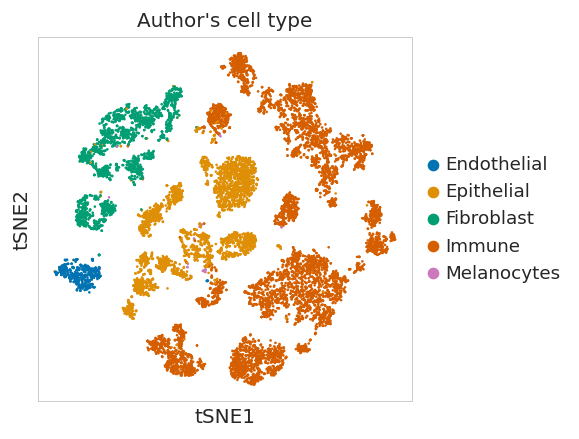

In [6]:
sc.tl.pca(adata_egfr, svd_solver='arpack')
sc.tl.tsne(adata_egfr, n_pcs=20, perplexity=30)
sc.pl.tsne(adata_egfr, color=["Author's cell type"], ncols=1)

In [ ]:
# Filter out group, practically no cells
# cc_egfr = cc_egfr[
#         (cc_egfr.obs["sampling site (standardized)"] != "Anatomic site of Origin for Matched Normal Tissue")
#     ]

/home/creixell/miniconda3/envs/pf2_env/lib/python3.13/site-packages/scanpy/tools/_score_genes.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


/home/creixell/miniconda3/envs/pf2_env/lib/python3.13/site-packages/scanpy/tools/_score_genes.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


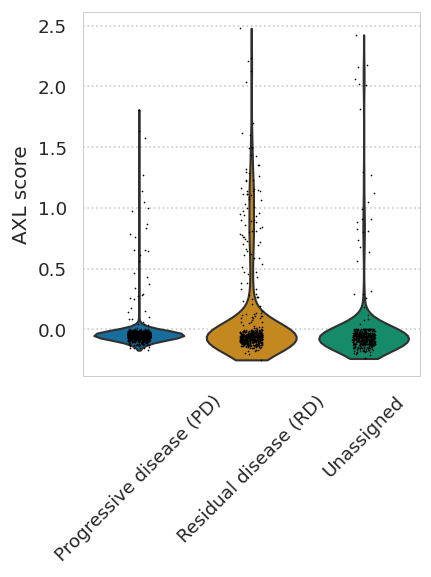

In [7]:
# Normalize AXL expression in EGFRm cancer cells
sc.tl.score_genes(cc_egfr, ["AXL"], score_name="AXL score")
sc.pl.violin(cc_egfr, ["AXL score"], rotation=45, groupby='Response to treatment')

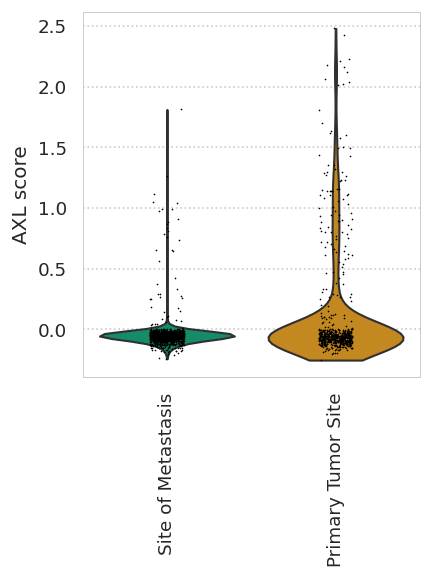

In [11]:
sc.pl.violin(cc_egfr, ["AXL score"], rotation=90, groupby='sampling site (standardized)', order=["Site of Metastasis", "Primary Tumor Site"])

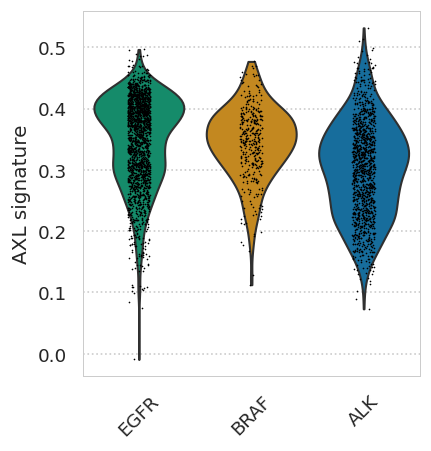

In [ ]:
sc.pl.violin(cc, ["AXL signature"], rotation=45, groupby="Driver gene", order=["EGFR", "BRAF", "ALK"]) # Very few ells in KRAS and ROS1

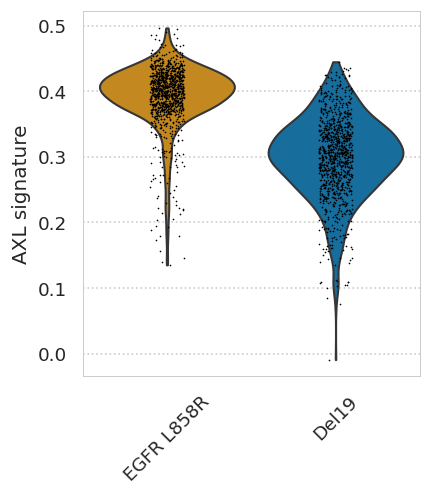

In [22]:
sc.pl.violin(cc_egfr, ["AXL signature"], rotation=45, groupby="Driver mutation", order=["EGFR L858R", "Del19"]) 

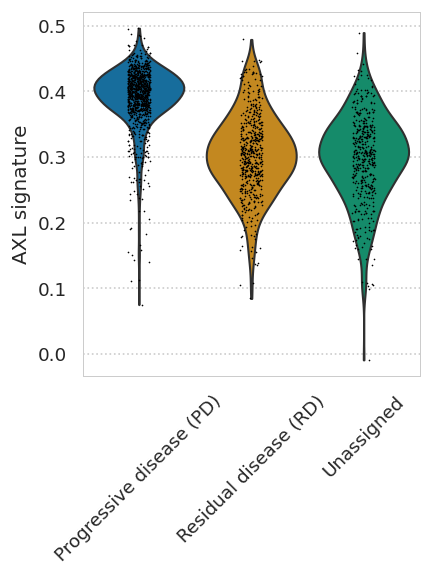

In [23]:
sc.pl.violin(cc_egfr, ["AXL signature"], rotation=45, groupby="Response to treatment") 

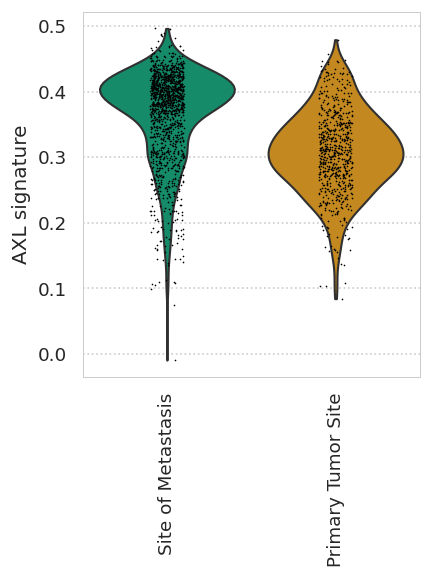

In [24]:
sc.pl.violin(cc_egfr, ["AXL signature"], rotation=90, groupby='sampling site (standardized)', order=["Site of Metastasis", "Primary Tumor Site"])